In [1]:
# Import modules
import torch
import e3nn
import numpy as np
import random
from model import InteractionModel
from conversion import Ha2kcal
from dataloader import GDB9Dataset, GDB9DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from datetime import datetime

/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`.",
)

In [3]:
# Define constants
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataloader
TRAIN_SIZE = 25000  # NOTE
EVAL_SIZE = 1000
TEST_SIZE = 10000

# Model
# - Atomic
MAX_Z = 10
DIM_ATOMS = 30
IRREPS_ATOM = e3nn.o3.Irreps(f"{DIM_ATOMS}x0e")
# - Distance
# NOTE
MU_MIN = 0.0
MU_MAX = 10.0
STEP = 0.5
R_CUT = 3.0
DIM_R = int(np.ceil((MU_MAX - MU_MIN) / STEP) + 1)
IRREPS_R = e3nn.o3.Irreps(f"{DIM_R}x0e")
IRREPS_SH = e3nn.o3.Irreps.spherical_harmonics(2)
# - Readout
DIM_MID = 15
# - Layer
N_INTERACTIONS = 3

# Trainer
N_EPOCHS = 1000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3
EARLY_STOP_THRESHOLD = 1000  # NOTE
MIN_EPOCHS = 10

DATASETS_PATH = "datasets/GDB9/gdb9_xyz"
CHECKPOINT_PATH = "GDB9_model.pt"

In [4]:
def loss_fn(predict, label):
    return (predict - label) ** 2

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
# Initiate model
model = InteractionModel(
    device=device,
    activation_fn=torch.nn.SiLU(),
    r_cut=R_CUT,
    max_z=MAX_Z,
    dim_atoms=DIM_ATOMS,
    dim_mid=DIM_MID,
    mu_min=MU_MIN,
    mu_max=MU_MAX,
    step=STEP,
    irreps_r=IRREPS_R,
    irreps_sh=IRREPS_SH,
    irreps_atom=IRREPS_ATOM,
    n_interactions=N_INTERACTIONS,
    energy_conversion=lambda x: x,
)

optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
# TODO scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda epoch: 0.95**epoch
)

In [7]:
dataset = GDB9Dataset(DATASETS_PATH)
train_dataset, eval_dataset, test_dataset = GDB9DataLoader(
    device, dataset, TRAIN_SIZE, EVAL_SIZE, TEST_SIZE
)

In [8]:
# Run train and evalutaion loop
train_loss = []
eval_loss = []
best_loss = torch.inf
best_plot = []

early_stop_counter = 0

for epoch in range(N_EPOCHS):
    model.train()
    train_loss.append([])
    plot = []
    for i, batch in enumerate(
        tqdm(train_dataset, desc=f"Epoch #{epoch + 1:02} (Train)")
    ):
        data, readout = model(batch)
        loss = loss_fn(data["e"], readout)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        plot.append((data["e"].item(), readout.item()))

        train_loss[-1].append(loss.item())
    scheduler.step()

    eval_loss.append([])
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(
            tqdm(eval_dataset, desc=f"Epoch #{epoch + 1:02} (Valid)")
        ):
            data, readout = model(batch)
            loss = loss_fn(data["e"], readout)
            eval_loss[-1].append(loss.item())

    if epoch > MIN_EPOCHS:
        if np.mean(eval_loss[-1]) < best_loss:
            best_loss = np.mean(eval_loss[-1])
            best_plot = plot
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_loss,
                },
                CHECKPOINT_PATH,
            )
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter > EARLY_STOP_THRESHOLD:
            break

Epoch #573 (Train):  36%|███▌      | 8988/25000 [00:45<01:20, 198.67it/s]


KeyboardInterrupt: 

In [9]:
# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]

In [10]:
# Test model
test_plot = []
test_loss = []
model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataset)):
        data, readout = model(batch)
        test_plot.append([data["e"].item(), readout.item()])
        test_loss.append(loss_fn(data["e"].item(), readout.item()))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:18<00:00, 529.88it/s]


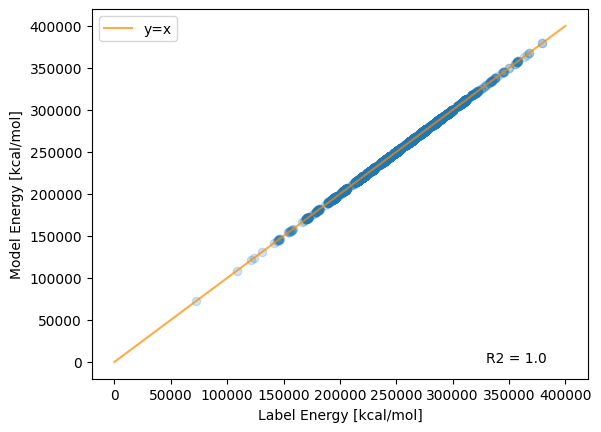

In [11]:
plt.scatter(
    [Ha2kcal(x[0]) for x in test_plot], [Ha2kcal(x[1]) for x in test_plot], alpha=0.2
)
axis = np.arange(0, 400000, 0.5)
plt.plot(axis, axis, "#FF8800", label="y=x", alpha=0.7)
plt.text(
    330000,
    20,
    f"R2 = {r2_score([Ha2kcal(x[0]) for x in test_plot], [Ha2kcal(x[1]) for x in test_plot]):.5}",
)
plt.xlabel("Label Energy [kcal/mol]")
plt.ylabel("Model Energy [kcal/mol]")
plt.legend()
plt.show()

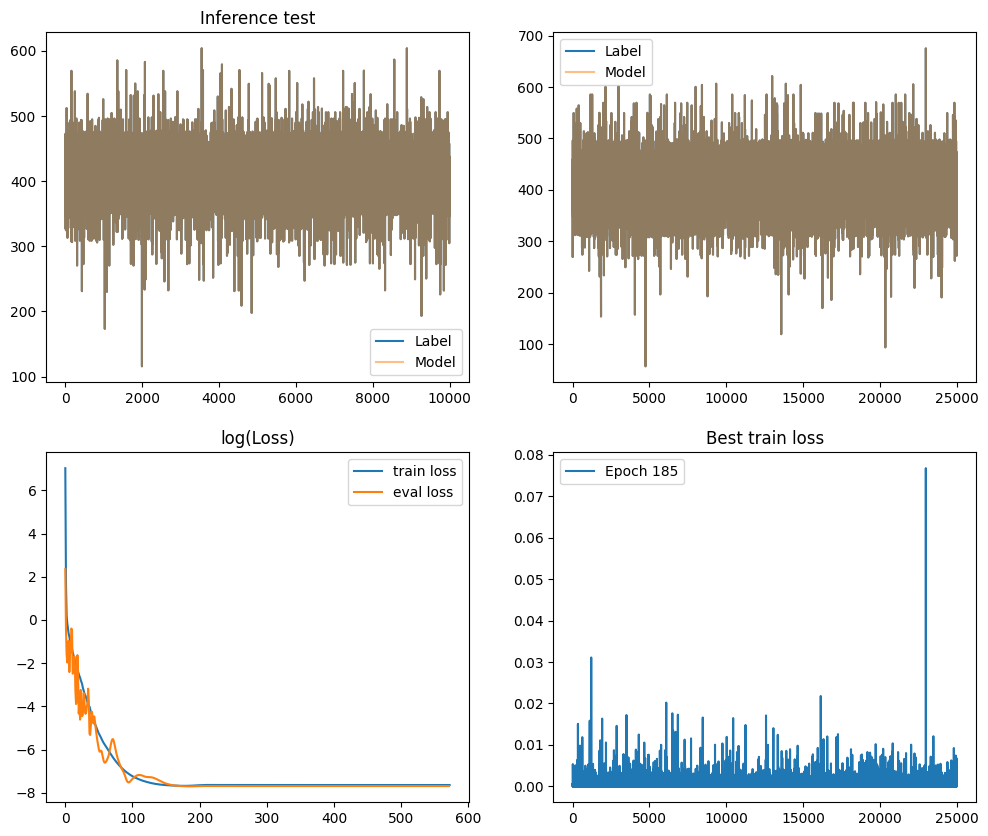

In [12]:
fig = plt.figure(figsize=(12, 10))
axes = fig.subplots(2, 2)


axes[0][0].plot([x[0] for x in test_plot], label="Label")
axes[0][0].plot([x[1] for x in test_plot], label="Model", alpha=0.5)
axes[0][0].legend()
axes[0][0].set_title("Inference test")

axes[0][1].plot([x[0] for x in best_plot], label="Label")
axes[0][1].plot([x[1] for x in best_plot], label="Model", alpha=0.5)
axes[0][1].legend()

axes[1][0].plot([np.log(np.mean(loss)) for loss in train_loss], label="train loss")
axes[1][0].plot([np.log(np.mean(loss)) for loss in eval_loss], label="eval loss")
axes[1][0].legend()
axes[1][0].set_title("log(Loss)")

axes[1][1].plot(train_loss[epoch], label=f"Epoch {epoch:02}")
axes[1][1].legend()
axes[1][1].set_title("Best train loss")

fig.show()

In [13]:
print(f"Best train loss : {loss:.2e} (MSE, Ha)")
print(f"Test loss       : {np.mean(test_loss):.2e} (MSE, Ha)")
print()
print(f"Test Error      : {Ha2kcal(np.mean(test_loss) ** 0.5):.2e} kcal/mol")

Best train loss : 4.50e-04 (MSE, Ha)
Test loss       : 4.45e-04 (MSE, Ha)

Test Error      : 1.32e+01 kcal/mol


In [14]:
print(
    f"Parameters in model : {sum([p.numel() for p in model.parameters() if p.requires_grad])}"
)

Parameters in model : 60211


In [15]:
r2_test = best_plot
print(f"Train R2 : {r2_score([x[0] for x in r2_test], [x[1] for x in r2_test])}")

Train R2 : 0.9999997114830455


In [16]:
r2_test = test_plot
print(f"Test R2 : {r2_score([x[0] for x in r2_test], [x[1] for x in r2_test])}")

Test R2 : 0.9999997318156896


In [17]:
name = "GDB9"
rmse = torch.tensor(test_loss) ** 0.5
std, mean = torch.std_mean(rmse)
mean, std = Ha2kcal(mean), Ha2kcal(std)

In [18]:
now = datetime.now()
date = f"{now.year}/{now.month:02}/{now.day:02}"
report = f"{name}({TRAIN_SIZE//1000}k) : {mean.item():.2f} ± {std.item():.2f} [kcal/mol]  {date}\n"
report_path = "GDB9_report.txt"
with open(report_path, "a", encoding="UTF-8") as report_file:
    report_file.write(report)